In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.10750,1.100000,1.30,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.81800,7.300000,1.40,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.88520,30.000000,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.76250,111.300000,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.76570,1.900000,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30T03:46:53.207Z,63.278200,-151.25170,7.400000,1.00,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
28331,2022-01-30T03:44:08.272Z,67.671500,-160.82990,6.200000,2.90,ml,NaN,NaN,NaN,0.5700,...,2022-02-25T03:00:49.040Z,"79 km NNW of Kiana, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
28332,2022-01-30T03:37:46.570Z,19.221167,-155.38916,31.940001,1.83,md,43.0,152.00,NaN,0.1300,...,2022-01-30T03:40:57.760Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.59,1.16,0.620,5.0,automatic,hv,hv
28333,2022-01-30T03:32:41.102Z,2.757300,128.23460,53.450000,4.50,mb,NaN,194.00,2.154,1.0300,...,2022-02-05T01:40:12.040Z,"Halmahera, Indonesia",earthquake,12.30,10.40,0.272,5.0,reviewed,us,us


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.10750,1.100000,1.30,ml,8.0,149.46,0.875,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.81800,7.300000,1.40,ml,11.0,154.64,0.119,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.88520,30.000000,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.76250,111.300000,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.76570,1.900000,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28330,2022-01-30 03:46:53.207000+00:00,63.278200,-151.25170,7.400000,1.00,ml,NaN,NaN,NaN,0.6600,...,2022-02-25T00:07:27.831Z,"37 km SE of Denali National Park, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
28331,2022-01-30 03:44:08.272000+00:00,67.671500,-160.82990,6.200000,2.90,ml,NaN,NaN,NaN,0.5700,...,2022-02-25T03:00:49.040Z,"79 km NNW of Kiana, Alaska",earthquake,NaN,0.60,NaN,NaN,reviewed,ak,ak
28332,2022-01-30 03:37:46.570000+00:00,19.221167,-155.38916,31.940001,1.83,md,43.0,152.00,NaN,0.1300,...,2022-01-30T03:40:57.760Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.59,1.16,0.620,5.0,automatic,hv,hv
28333,2022-01-30 03:32:41.102000+00:00,2.757300,128.23460,53.450000,4.50,mb,NaN,194.00,2.154,1.0300,...,2022-02-05T01:40:12.040Z,"Halmahera, Indonesia",earthquake,12.30,10.40,0.272,5.0,reviewed,us,us


In [5]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [6]:
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [7]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.384000,-117.10750,1.100000,1.30,1.641433e+09
1,38.181000,-117.81800,7.300000,1.40,1.641433e+09
2,61.340700,-149.88520,30.000000,1.50,1.641432e+09
3,62.870300,-150.76250,111.300000,2.10,1.641432e+09
4,64.014500,-148.76570,1.900000,1.50,1.641431e+09
...,...,...,...,...,...
28330,63.278200,-151.25170,7.400000,1.00,1.643514e+09
28331,67.671500,-160.82990,6.200000,2.90,1.643514e+09
28332,19.221167,-155.38916,31.940001,1.83,1.643514e+09
28333,2.757300,128.23460,53.450000,4.50,1.643514e+09


In [8]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [9]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [10]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [11]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['latitude'], axis = 1)

y = cleaned_df_dropped[['latitude']]

In [12]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((28329, 4), (28329, 1))

In [13]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [15]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 74.47375926959104, 	R2 score: 0.8163697432499698, 	Model score: 0.8163697432499698
n_estimators=3:
	Mean Squared Error: 65.33523824104874, 	R2 score: 0.8389026324077751, 	Model score: 0.8389026324077751
n_estimators=4:
	Mean Squared Error: 56.90007220676937, 	R2 score: 0.8597012562424702, 	Model score: 0.8597012562424702
n_estimators=5:
	Mean Squared Error: 55.72503443122578, 	R2 score: 0.8625985517534026, 	Model score: 0.8625985517534026
n_estimators=6:
	Mean Squared Error: 54.3917905821467, 	R2 score: 0.8658859366352446, 	Model score: 0.8658859366352446
n_estimators=7:
	Mean Squared Error: 52.96300322385807, 	R2 score: 0.8694089035435482, 	Model score: 0.8694089035435482
n_estimators=8:
	Mean Squared Error: 52.81580151430455, 	R2 score: 0.8697718594086, 	Model score: 0.8697718594086
n_estimators=9:
	Mean Squared Error: 51.265418649248275, 	R2 score: 0.8735946448616687, 	Model score: 0.8735946448616687
n_estimators=10:
	Mean Squared Error: 50.42096

In [16]:
#create and run model: Now with 200 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 50:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 74.47375926959104, 	R2: 0.8163697432499698, 	Model score: 0.8163697432499698
n_estimators=3:
	Mean Squared Error: 65.33523824104874, 	R2: 0.8389026324077751, 	Model score: 0.8389026324077751
n_estimators=4:
	Mean Squared Error: 56.90007220676937, 	R2: 0.8597012562424702, 	Model score: 0.8597012562424702
n_estimators=5:
	Mean Squared Error: 55.72503443122578, 	R2: 0.8625985517534026, 	Model score: 0.8625985517534026
n_estimators=6:
	Mean Squared Error: 54.3917905821467, 	R2: 0.8658859366352446, 	Model score: 0.8658859366352446
n_estimators=7:
	Mean Squared Error: 52.96300322385807, 	R2: 0.8694089035435482, 	Model score: 0.8694089035435482
n_estimators=8:
	Mean Squared Error: 52.81580151430455, 	R2: 0.8697718594086, 	Model score: 0.8697718594086
n_estimators=9:
	Mean Squared Error: 51.265418649248275, 	R2: 0.8735946448616687, 	Model score: 0.8735946448616687
n_estimators=10:
	Mean Squared Error: 50.420964202777036, 	R2: 0.8756768196886152, 	Model scor

Cross-Validation

In [17]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 2833  2834  2835 ... 28326 28327 28328] | test: [   0    1    2 ... 2830 2831 2832]
Train: [    0     1     2 ... 28326 28327 28328] | test: [2833 2834 2835 ... 5663 5664 5665]
Train: [    0     1     2 ... 28326 28327 28328] | test: [5666 5667 5668 ... 8496 8497 8498]
Train: [    0     1     2 ... 28326 28327 28328] | test: [ 8499  8500  8501 ... 11329 11330 11331]
Train: [    0     1     2 ... 28326 28327 28328] | test: [11332 11333 11334 ... 14162 14163 14164]
Train: [    0     1     2 ... 28326 28327 28328] | test: [14165 14166 14167 ... 16995 16996 16997]
Train: [    0     1     2 ... 28326 28327 28328] | test: [16998 16999 17000 ... 19828 19829 19830]
Train: [    0     1     2 ... 28326 28327 28328] | test: [19831 19832 19833 ... 22661 22662 22663]
Train: [    0     1     2 ... 28326 28327 28328] | test: [22664 22665 22666 ... 25494 25495 25496]
Train: [    0     1     2 ... 25494 25495 25496] | test: [25497 25498 25499 ... 28326 28327 28328]


In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), cv=k_fold, n_jobs=-1)
    print(cv_score)

[0.83076946 0.86592046 0.8065655  0.87393221 0.88796312 0.85765236
 0.86655092 0.84227621 0.87513985 0.88312751]


In [19]:
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [20]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

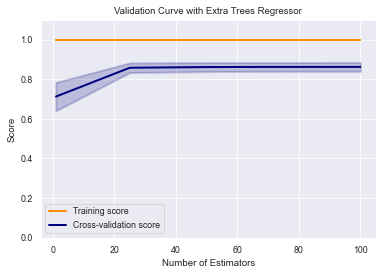

In [21]:

plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [22]:
testpred = best_model.predict(X_test)
actual_lat = y_test
testpredict = []
for item in testpred:
    testpredict.append(item)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 6.793794


In [23]:
print(actual_lat)

        latitude
8870   38.787000
3587   38.230500
6356  -28.686100
11229  37.627667
2900   62.446400
...          ...
5282   38.556100
13083  38.167000
21510  46.192000
25047   7.367500
19988  61.482700

[9349 rows x 1 columns]


In [24]:
lat_pred = actual_lat
lat_pred['Predicted'] = testpredict


In [25]:
lat_pred = lat_pred.rename(columns={'latitude': 'Actual'})

In [26]:
lat_pred

,Actual,Predicted
8870,38.787000,38.783419
3587,38.230500,41.608269
6356,-28.686100,-32.391900
11229,37.627667,37.670514
2900,62.446400,62.142861
...,...,...
5282,38.556100,38.617690
13083,38.167000,38.055214
21510,46.192000,46.195796
25047,7.367500,-8.530216


In [27]:
lat_pred_all = lat_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lat_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
8870,38.787000,38.783419,2022-01-07 01:20:12.430000+00:00,38.787000,-122.734167,1.72,0.12,md,14.0,110.00,...,"2km ENE of The Geysers, CA",earthquake,0.26,0.35,0.02300,4.0,reviewed,nc,nc,1.641518e+09
3587,38.230500,41.608269,2021-12-22 13:12:47+00:00,38.230500,-112.381000,8.81,1.95,ml,23.0,185.00,...,"11 km NW of Circleville, Utah",earthquake,0.59,0.74,0.11600,8.0,reviewed,uu,uu,1.640179e+09
6356,-28.686100,-32.391900,2021-12-14 04:23:55.138000+00:00,-28.686100,-71.555500,17.79,5.50,mwr,NaN,65.00,...,"78 km W of Vallenar, Chile",earthquake,4.20,3.30,NaN,NaN,reviewed,us,guc,1.639456e+09
11229,37.627667,37.670514,2022-01-26 07:41:30.140000+00:00,37.627667,-118.893500,2.71,0.11,md,15.0,103.00,...,"8km E of Mammoth Lakes, CA",earthquake,0.34,0.50,0.17800,13.0,reviewed,nc,nc,1.643183e+09
2900,62.446400,62.142861,2021-12-24 20:15:05.365000+00:00,62.446400,-148.337100,33.50,1.70,ml,NaN,NaN,...,"72 km N of Chickaloon, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak,1.640377e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,38.556100,38.617690,2021-12-17 13:30:12.501000+00:00,38.556100,-119.467700,6.70,0.90,ml,6.0,150.19,...,California-Nevada border region,earthquake,NaN,2.90,0.37000,2.0,reviewed,nn,nn,1.639748e+09
13083,38.167000,38.055214,2022-01-20 09:24:06.963000+00:00,38.167000,-117.875700,13.20,0.80,ml,9.0,163.88,...,"32 km SE of Mina, Nevada",earthquake,NaN,0.90,0.49000,4.0,automatic,nn,nn,1.642671e+09
21510,46.192000,46.195796,2022-02-16 17:31:26.600000+00:00,46.192000,-122.202333,4.62,-0.20,md,9.0,166.00,...,Washington,earthquake,0.81,0.74,0.39126,4.0,reviewed,uw,uw,1.645033e+09
25047,7.367500,-8.530216,2022-02-06 18:32:46.652000+00:00,7.367500,-80.497000,10.00,4.60,mb,NaN,69.00,...,"6 km NW of Ave María, Panama",earthquake,6.80,1.90,0.12500,19.0,reviewed,us,us,1.644172e+09


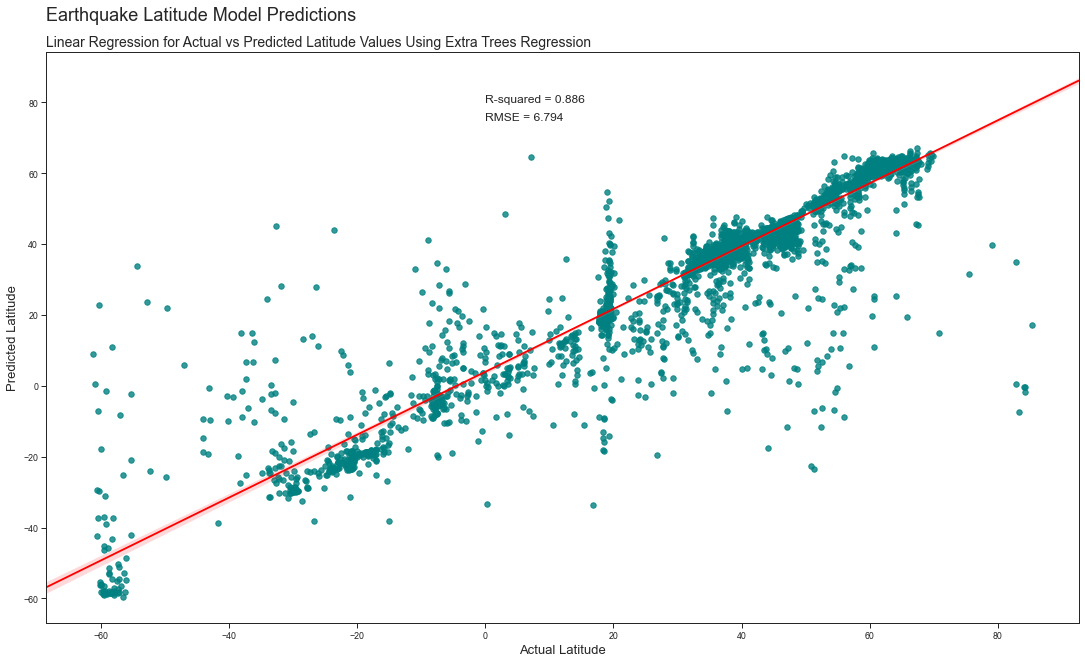

In [28]:
x = np.array(lat_pred_all['latitude'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lat_pred_all['latitude'], testpredict)), (0, 80),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 75), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()

Test with new data from USGS


In [29]:

page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-10T00:52:46.560Z,19.246000,-155.383667,31.969999,2.10,md,44.0,140.0,NaN,0.12,...,2022-03-10T00:56:07.600Z,"11 km ENE of Pāhala, Hawaii",earthquake,0.50,0.96,0.960000,19.0,automatic,hv,hv
1,2022-03-10T00:44:03.950Z,36.082833,-117.903167,5.160000,0.97,ml,8.0,236.0,0.05228,0.13,...,2022-03-10T00:47:30.038Z,"6km NE of Coso Junction, CA",earthquake,0.64,1.11,0.162000,8.0,automatic,ci,ci
2,2022-03-10T00:31:57.460Z,33.295667,-116.749833,18.750000,0.90,ml,22.0,59.0,0.05999,0.22,...,2022-03-10T00:35:31.606Z,"6km NNE of Lake Henshaw, CA",earthquake,0.38,0.59,0.208000,17.0,automatic,ci,ci
3,2022-03-10T00:24:38.810Z,19.156166,-155.479828,30.010000,2.32,ml,42.0,166.0,NaN,0.17,...,2022-03-10T00:30:55.472Z,"5 km S of Pāhala, Hawaii",earthquake,0.61,0.85,3.220000,8.0,automatic,hv,hv
4,2022-03-10T00:14:03.410Z,17.973000,-66.860833,9.530000,1.91,md,6.0,200.0,NaN,0.08,...,2022-03-10T00:39:36.940Z,"3 km E of Maria Antonia, Puerto Rico",earthquake,0.57,3.47,0.088928,4.0,reviewed,pr,pr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2022-03-09T01:49:28.706Z,64.911800,-148.669700,14.400000,2.20,ml,NaN,NaN,NaN,1.04,...,2022-03-09T02:41:01.576Z,"31 km WNW of Ester, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
272,2022-03-09T01:49:19.867Z,2.580500,128.433000,53.240000,5.10,mb,NaN,82.0,2.08800,0.84,...,2022-03-09T02:08:09.040Z,"105 km NNE of Tobelo, Indonesia",earthquake,7.40,7.50,0.048000,140.0,reviewed,us,us
273,2022-03-09T01:37:25.891Z,61.931900,-149.963900,25.000000,2.30,ml,NaN,NaN,NaN,0.65,...,2022-03-09T02:13:09.040Z,"20 km N of Willow, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak
274,2022-03-09T01:35:47.780Z,47.476167,-123.210000,13.390000,0.94,ml,17.0,74.0,0.03487,0.18,...,2022-03-09T04:34:55.530Z,"9 km NW of Hoodsport, Washington",earthquake,0.38,0.60,0.162154,5.0,reviewed,uw,uw


In [30]:


test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag,Unix Time
0,19.246000,-155.383667,31.969999,2.10,1.646874e+09
1,36.082833,-117.903167,5.160000,0.97,1.646873e+09
2,33.295667,-116.749833,18.750000,0.90,1.646872e+09
3,19.156166,-155.479828,30.010000,2.32,1.646872e+09
4,17.973000,-66.860833,9.530000,1.91,1.646871e+09
...,...,...,...,...,...
271,64.911800,-148.669700,14.400000,2.20,1.646791e+09
272,2.580500,128.433000,53.240000,5.10,1.646791e+09
273,61.931900,-149.963900,25.000000,2.30,1.646790e+09
274,47.476167,-123.210000,13.390000,0.94,1.646790e+09


In [31]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [32]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['latitude'], axis = 1)

y_test_data = cleaned_test_df[['latitude']]


In [33]:

pred_data_y = best_model.predict(X_test_data)


In [34]:

test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix Time,Predicted
0,19.246000,-155.383667,31.969999,2.10,1.646874e+09,19.225677
1,36.082833,-117.903167,5.160000,0.97,1.646873e+09,36.817266
2,33.295667,-116.749833,18.750000,0.90,1.646872e+09,33.720618
3,19.156166,-155.479828,30.010000,2.32,1.646872e+09,19.182457
4,17.973000,-66.860833,9.530000,1.91,1.646871e+09,17.957629
...,...,...,...,...,...,...
271,64.911800,-148.669700,14.400000,2.20,1.646791e+09,61.900406
272,2.580500,128.433000,53.240000,5.10,1.646791e+09,18.883277
273,61.931900,-149.963900,25.000000,2.30,1.646790e+09,61.987887
274,47.476167,-123.210000,13.390000,0.94,1.646790e+09,44.019672


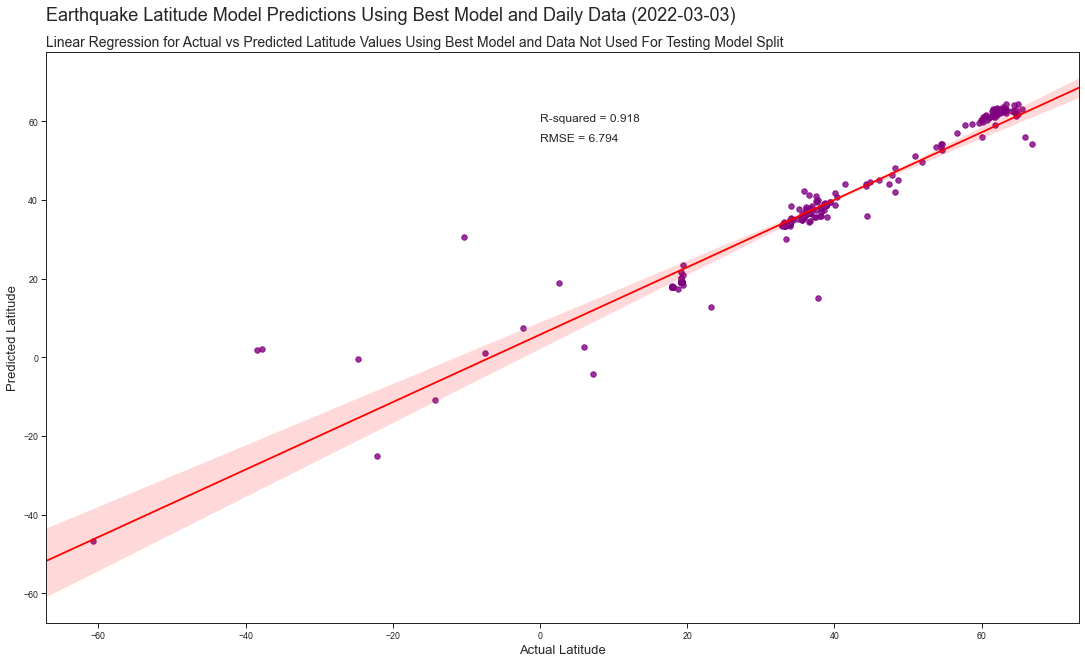

In [35]:

x = np.array(test_pred_data['latitude'])
y = np.array(pred_data_y)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions Using Best Model and Daily Data (2022-03-03)', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 60),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 55), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()

In [38]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")

Connected to database...


In [41]:
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lat_pred_all.to_sql('earthquake_etrees_lat', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lat_pred_all.to_sql('earthquake_etrees_lat', conn, if_exists='replace', index=False)

In [42]:
# Close connection to SQLite database
conn.close()
connection.close()